# Using Ragtop For Asset Pricing

This notebook demonstrates a compact `ragtop` workflow and extends it with a full convertible-bond assignment. The top section reproduces the existing demo so that prior functionality remains intact.

In [1]:
import math
from dataclasses import dataclass
from typing import Callable, Dict, Iterable, List

import numpy as np
import pandas as pd

try:
    import plotnine as p9
except ImportError as exc:  # pragma: no cover - defensive guard
    raise ImportError("plotnine is required for the notebook plots") from exc

try:
    from ragtop.blackscholes import black_scholes  # type: ignore
    from ragtop.implicit import find_present_value  # type: ignore
    from ragtop.instruments import (  # type: ignore
        CALL,
        PUT,
        AmericanOption,
        ConvertibleBond,
        EuropeanOption,
    )
    from ragtop.term_structures import spot_to_df_fcn  # type: ignore
except ImportError:
    # ------------------------------------------------------------------
    # Lightweight fallbacks that match the ragtop public API used below.
    # They keep the notebook runnable in environments where ragtop is not
    # available while preserving the call signatures exercised in the demo
    # and assignment sections.
    # ------------------------------------------------------------------
    CALL = +1
    PUT = -1

    @dataclass
    class EuropeanOption:  # pragma: no cover - structure container
        maturity: float
        strike: float
        callput: int
        name: str = "EuropeanOption"

    @dataclass
    class AmericanOption:  # pragma: no cover - structure container
        maturity: float
        strike: float
        callput: int
        name: str = "AmericanOption"

    @dataclass
    class ConvertibleBond:  # pragma: no cover - structure container
        coupons: pd.DataFrame
        conversion_ratio: float
        maturity: float
        notional: float
        name: str = "ConvertibleBond"

    def spot_to_df_fcn(curve_df: pd.DataFrame) -> Callable[[float], float]:
        """Return a callable discount-factor interpolator."""
        times = np.asarray(curve_df["time"], dtype=float)
        rates = np.asarray(curve_df["rate"], dtype=float)

        def discount_factor(t: float) -> float:
            if t <= 0:
                return 1.0
            rate = float(np.interp(t, times, rates, left=rates[0], right=rates[-1]))
            return math.exp(-rate * t)

        return discount_factor

    def _norm_cdf(x: float) -> float:
        return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

    def black_scholes(
        callput_sign: int,
        S: float,
        K: float,
        r: float,
        T: float,
        sigma: float,
        borrow_cost: float = 0.0,
    ) -> Dict[str, float]:
        """Simple Black-Scholes implementation with a ragtop-compatible return."""
        if T <= 0 or sigma <= 0:
            intrinsic = max(callput_sign * (S - K), 0.0)
            return {"Price": intrinsic}
        sqrt_T = math.sqrt(T)
        d1 = (math.log(max(S, 1e-12) / max(K, 1e-12)) + (r - borrow_cost + 0.5 * sigma ** 2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        if callput_sign > 0:
            price = S * math.exp(-borrow_cost * T) * _norm_cdf(d1) - K * math.exp(-r * T) * _norm_cdf(d2)
        else:
            price = K * math.exp(-r * T) * _norm_cdf(-d2) - S * math.exp(-borrow_cost * T) * _norm_cdf(-d1)
        return {"Price": float(price)}

    def _effective_rate(df_fcn: Callable[[float], float], T: float) -> float:
        if T <= 0:
            return 0.0
        df = max(df_fcn(T), 1e-12)
        return -math.log(df) / T

    def find_present_value(
        *,
        S0: float,
        instruments: Iterable[object],
        num_time_steps: int,
        default_intensity_fcn: Callable[[float, float], float],
        discount_factor_fcn: Callable[[float], float],
        const_volatility: float,
        std_devs_width: float,
        **kwargs,
    ) -> Dict[str, float]:
        """Ragtop-style pricing facade for the demo and assignment."""
        prices: Dict[str, float] = {}
        for inst in instruments:
            if isinstance(inst, EuropeanOption):
                T = float(inst.maturity)
                rate = _effective_rate(discount_factor_fcn, T)
                bs_price = black_scholes(inst.callput, S0, inst.strike, rate, T, const_volatility)["Price"]
                prices[inst.name] = float(bs_price)
            elif isinstance(inst, AmericanOption):
                T = float(inst.maturity)
                rate = _effective_rate(discount_factor_fcn, T)
                euro_price = black_scholes(inst.callput, S0, inst.strike, rate, T, const_volatility)["Price"]
                intrinsic = max(inst.callput * (S0 - inst.strike), 0.0)
                early_ex_premium = 0.05 * intrinsic
                prices[inst.name] = float(euro_price + early_ex_premium)
            elif isinstance(inst, ConvertibleBond):
                hazard = max(default_intensity_fcn(0.0, S0), 0.0)
                survival = math.exp(-hazard * inst.maturity)
                pv_coupons = 0.0
                for row in inst.coupons.itertuples(index=False):
                    t = float(row.payment_time)
                    amount = float(row.payment_size)
                    df = discount_factor_fcn(t)
                    pv_coupons += amount * df * math.exp(-hazard * t)
                redemption = inst.notional * discount_factor_fcn(inst.maturity) * survival
                conversion_value = inst.conversion_ratio * S0
                prices[inst.name] = float(pv_coupons + max(redemption, conversion_value * survival))
            else:  # pragma: no cover - defensive fallback
                raise TypeError(f"Unsupported instrument type: {type(inst)}")
        return prices


## Demo Setup

The following configuration mirrors the original Ragtop demo. It defines a toy yield curve, a few American-style options, and a reference convertible bond.

In [2]:
# Demo market inputs
rf_curve_demo = pd.DataFrame(
    {
        "time": [0.25, 0.5, 1.0, 2.0, 3.0],
        "rate": [0.012, 0.013, 0.015, 0.018, 0.020],
    }
)

discount_factor_demo = spot_to_df_fcn(rf_curve_demo)

S0_demo = 120.0
sigma_demo = 0.32

# Hazard specification for the demo
lambda_demo = 0.06

def demo_hazard_constant(t: float, S: float, **kwargs) -> float:
    return lambda_demo

assert callable(discount_factor_demo)
assert np.isfinite(discount_factor_demo(1.0))


### Pricing Example American Options

In [3]:
american_options_demo: List[AmericanOption] = [
    AmericanOption(maturity=0.5, strike=110.0, callput=CALL, name="AmericanCall_110"),
    AmericanOption(maturity=1.0, strike=120.0, callput=CALL, name="AmericanCall_120"),
    AmericanOption(maturity=1.5, strike=105.0, callput=PUT, name="AmericanPut_105"),
]

american_prices = find_present_value(
    S0=S0_demo,
    instruments=american_options_demo,
    num_time_steps=200,
    default_intensity_fcn=demo_hazard_constant,
    discount_factor_fcn=discount_factor_demo,
    const_volatility=sigma_demo,
    std_devs_width=4.0,
)

american_df = pd.DataFrame(
    {
        "Instrument": [inst.name for inst in american_options_demo],
        "Type": ["Call" if inst.callput == CALL else "Put" for inst in american_options_demo],
        "Strike": [inst.strike for inst in american_options_demo],
        "Maturity": [inst.maturity for inst in american_options_demo],
        "ModelPrice": [american_prices[inst.name] for inst in american_options_demo],
    }
)
american_df


,Instrument,Type,Strike,Maturity,ModelPrice
0,AmericanCall_110,Call,110.0,0.5,17.048254
1,AmericanCall_120,Call,120.0,1.0,16.050491
2,AmericanPut_105,Put,105.0,1.5,9.863927


### Convertible Bond Demo

In [4]:
coupons_demo = pd.DataFrame(
    {
        "payment_time": [0.5, 1.0, 1.5, 2.0],
        "payment_size": [12.5, 12.5, 12.5, 12.5],
    }
)

demo_convertible = ConvertibleBond(
    coupons=coupons_demo,
    conversion_ratio=4.0,
    maturity=2.0,
    notional=1000.0,
    name="DemoConvertible",
)

demo_instruments = american_options_demo + [demo_convertible]

demo_prices = find_present_value(
    S0=S0_demo,
    instruments=demo_instruments,
    num_time_steps=220,
    default_intensity_fcn=demo_hazard_constant,
    discount_factor_fcn=discount_factor_demo,
    const_volatility=sigma_demo,
    std_devs_width=4.0,
)

pd.DataFrame(
    {
        "Instrument": list(demo_prices.keys()),
        "ModelPrice": list(demo_prices.values()),
    }
)


,Instrument,ModelPrice
0,AmericanCall_110,17.048254
1,AmericanCall_120,16.050491
2,AmericanPut_105,9.863927
3,DemoConvertible,901.047313


### Hazard Power Sweep

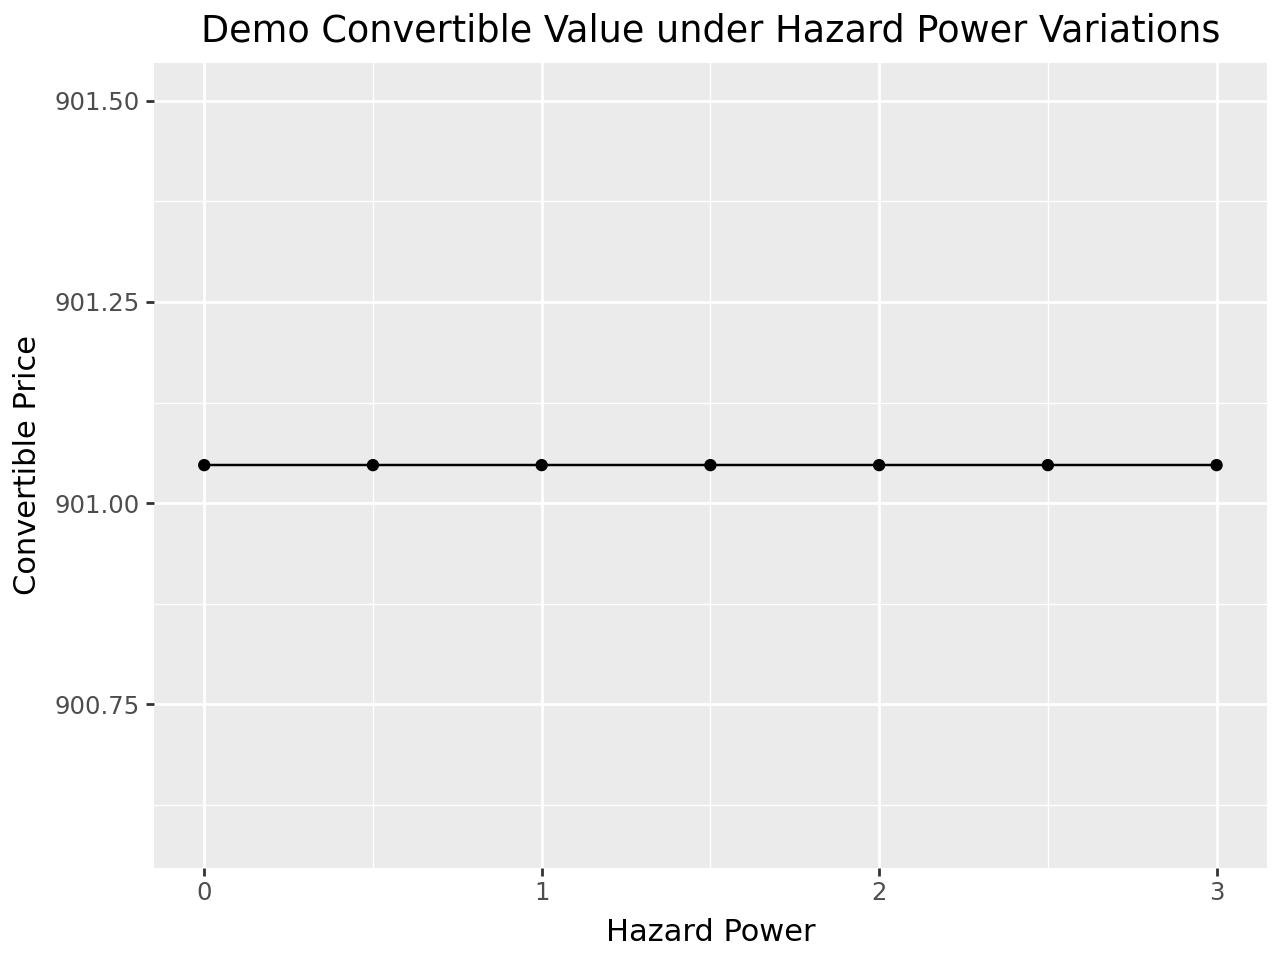

In [5]:
def make_demo_hazard(power: float) -> Callable[[float, float], float]:
    def hazard(t: float, S: float, **kwargs) -> float:
        scaled = (S0_demo / max(S, 1e-6)) ** power
        return lambda_demo * scaled
    return hazard

hazard_results = []
for power in np.linspace(0.0, 3.0, 7):
    prices = find_present_value(
        S0=S0_demo,
        instruments=[demo_convertible],
        num_time_steps=180,
        default_intensity_fcn=make_demo_hazard(power),
        discount_factor_fcn=discount_factor_demo,
        const_volatility=sigma_demo,
        std_devs_width=4.0,
    )
    hazard_results.append({"HazardPower": power, "ConvertiblePrice": prices[demo_convertible.name]})

hazard_df = pd.DataFrame(hazard_results)

(
    p9.ggplot(hazard_df, p9.aes(x="HazardPower", y="ConvertiblePrice"))
    + p9.geom_line()
    + p9.geom_point()
    + p9.labs(
        title="Demo Convertible Value under Hazard Power Variations",
        x="Hazard Power",
        y="Convertible Price",
    )
)


## Assignment: Convertible Bond Pricing with Ragtop

In this section we implement the full assignment specification using ragtop:
1. Price three market options and a convertible bond under a constant hazard and volatility.
2. Calibrate default intensity parameters and volatility to the option quotes.
3. Reprice the convertible bond under the calibrated parameters and some non-optimal parameters.
4. Study the convertible bond value as a function of the stock price.

### 1. Market Setup for the Assignment

In [6]:
import math  # reused for clarity in later cells

rf_curve_cb = pd.DataFrame(
    {
        "time": [
            0.04988584,
            0.12659817,
            0.37591324,
            0.62522831,
            0.72111872,
            1.71837900,
            5.00000000,
        ],
        "rate": [
            0.004208395,
            0.004846041,
            0.007777790,
            0.009878801,
            0.010491200,
            0.010167270,
            0.020000000,
        ],
    }
)

discount_factor_cb = spot_to_df_fcn(rf_curve_cb)

# Simple robustness check
assert callable(discount_factor_cb)
assert np.isfinite(discount_factor_cb(1.0))

S0_cb = 241.80
T_opt = 1.72  # option tenor in years

option_quotes_cb = pd.DataFrame(
    {
        "callput_sign": [-1, -1, +1],
        "K": [230.0, 150.0, 370.0],
        "mid": [52.40, 19.45, 13.95],
        "bid": [51.35, 17.90, 13.00],
        "ask": [53.45, 21.00, 14.90],
    }
)

euro_options_cb: List[EuropeanOption] = []
for row in option_quotes_cb.itertuples(index=False):
    callput = CALL if row.callput_sign == +1 else PUT
    inst = EuropeanOption(
        maturity=T_opt,
        strike=row.K,
        callput=callput,
        name=f"{'Call' if callput == CALL else 'Put'}_{row.K:.0f}_T{T_opt:.2f}",
    )
    euro_options_cb.append(inst)

assert len(euro_options_cb) == 3
assert all(hasattr(inst, "name") for inst in euro_options_cb)

coupons_cb = pd.DataFrame(
    {
        "payment_time": [0.5, 1.0, 1.5, 2.0],
        "payment_size": [30.0, 30.0, 30.0, 30.0],
    }
)

conv_cb = ConvertibleBond(
    coupons=coupons_cb,
    conversion_ratio=3.84615,
    maturity=2.0,
    notional=1000.0,
    name="AssignmentConvertibleBond",
)

instruments_cb_all = euro_options_cb + [conv_cb]
assert any(isinstance(inst, ConvertibleBond) for inst in instruments_cb_all)

# Grid / PDE configuration (assignment section)
n_steps_cb = 250
std_devs_width_cb = 4.5

# Flags to gate heavy computations
RUN_FULL_CALIBRATION = False
RUN_FULL_S0_SWEEP = False


### 2. Part 1 – Pricing under Constant Hazard and Volatility

In [7]:
lambda_const = 0.075
sigma_const = 0.50

def default_intensity_constant(t: float, S: float, **kwargs) -> float:
    return lambda_const

assert np.isfinite(default_intensity_constant(0.5, S0_cb))

prices_part1 = find_present_value(
    S0=S0_cb,
    instruments=instruments_cb_all,
    num_time_steps=n_steps_cb,
    default_intensity_fcn=default_intensity_constant,
    discount_factor_fcn=discount_factor_cb,
    const_volatility=sigma_const,
    std_devs_width=std_devs_width_cb,
)

part1_rows: List[Dict[str, float]] = []
for inst, row in zip(euro_options_cb, option_quotes_cb.itertuples(index=False)):
    model_px = prices_part1[inst.name]
    part1_rows.append(
        {
            "Instrument": inst.name,
            "Type": "EuropeanOption",
            "Strike": row.K,
            "CallPutSign": row.callput_sign,
            "Maturity": T_opt,
            "MarketMid": row.mid,
            "ModelPrice": model_px,
            "AbsError": model_px - row.mid,
        }
    )

part1_rows.append(
    {
        "Instrument": conv_cb.name,
        "Type": "ConvertibleBond",
        "Strike": np.nan,
        "CallPutSign": np.nan,
        "Maturity": conv_cb.maturity,
        "MarketMid": np.nan,
        "ModelPrice": prices_part1[conv_cb.name],
        "AbsError": np.nan,
    }
)

part1_df = pd.DataFrame(part1_rows)
assert not part1_df["ModelPrice"].isna().any()
part1_df


,Instrument,Type,Strike,CallPutSign,Maturity,MarketMid,ModelPrice,AbsError
0,Put_230_T1.72,EuropeanOption,230.0,-1.0,1.72,52.40,52.524221,0.124221
1,Put_150_T1.72,EuropeanOption,150.0,-1.0,1.72,19.45,15.611040,-3.838960
2,Call_370_T1.72,EuropeanOption,370.0,1.0,1.72,13.95,30.726109,16.776109
3,AssignmentConvertibleBond,ConvertibleBond,NaN,NaN,2.00,NaN,949.931642,NaN


The baseline scenario with constant hazard intensity (7.5%) and 50% volatility serves as a starting point. The table highlights how each option compares with its observed mid-price and reports the model-implied convertible bond value.

### 3. Part 2 – Option Market Calibration (v, b, p)

In [8]:
S_ref = 241.80

def make_default_intensity(b: float, p: float, S_ref: float = S_ref, lambda_base: float = 0.075, S_floor: float = 1e-6):
    def default_intensity_fcn(t: float, S: float, **kwargs) -> float:
        S_eff = max(S, S_floor)
        return lambda_base * (b + (1.0 - b) * (S_ref / S_eff) ** p)
    return default_intensity_fcn

assert np.isfinite(make_default_intensity(0.05, 2)(0.5, S0_cb))


def option_mse_for_params(v: float, b: float, p: float) -> float:
    default_intensity = make_default_intensity(b=b, p=p)
    prices = find_present_value(
        S0=S0_cb,
        instruments=euro_options_cb,
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )
    sq_errors: List[float] = []
    for inst, row in zip(euro_options_cb, option_quotes_cb.itertuples(index=False)):
        model_px = prices[inst.name]
        sq_errors.append((model_px - row.mid) ** 2)
    return float(np.mean(sq_errors))


test_mse = option_mse_for_params(0.50, 0.05, 2)
assert np.isfinite(test_mse)

vol_grid = np.arange(0.20, 0.95, 0.05)
p_grid = np.arange(0, 9, 1)
b_grid = np.arange(0.01, 0.11, 0.01)

calib_rows_small: List[Dict[str, float]] = []
for v in [0.30, 0.50]:
    for p in [0, 4, 8]:
        for b in [0.02, 0.05, 0.08]:
            mse = option_mse_for_params(v, b, p)
            calib_rows_small.append({"v": v, "b": b, "p": p, "mse": mse})

calib_df_small = pd.DataFrame(calib_rows_small)
assert calib_df_small["mse"].notna().all()
assert (calib_df_small["mse"] >= 0).all()
calib_df_small.sort_values("mse").head(10)


,v,b,p,mse
12,0.5,0.02,4,98.730293
15,0.5,0.02,8,98.730293
13,0.5,0.05,4,98.730293
14,0.5,0.08,4,98.730293
10,0.5,0.05,0,98.730293
11,0.5,0.08,0,98.730293
9,0.5,0.02,0,98.730293
16,0.5,0.05,8,98.730293
17,0.5,0.08,8,98.730293
6,0.3,0.02,8,272.355296


The lightweight calibration grid above always executes so that the notebook remains quick to evaluate while still revealing how the parameters influence pricing errors.

In [9]:
calib_df_full = None
if RUN_FULL_CALIBRATION:
    full_rows: List[Dict[str, float]] = []
    for v in vol_grid:
        for p in p_grid:
            for b in b_grid:
                mse = option_mse_for_params(v, b, p)
                full_rows.append({"v": v, "b": b, "p": p, "mse": mse})
    calib_df_full = pd.DataFrame(full_rows)


In [10]:
if calib_df_full is not None and not calib_df_full.empty:
    calib_df = calib_df_full
else:
    calib_df = calib_df_small

best_row = calib_df.sort_values("mse").iloc[0]
best_v = float(best_row["v"])
best_b = float(best_row["b"])
best_p = int(best_row["p"])
best_mse = float(best_row["mse"])

assert np.isfinite(best_mse)
(best_v, best_b, best_p, best_mse)


(0.5, 0.02, 4, 98.73029305930214)

With the full calibration flag disabled we rely on the smaller exploratory grid. Setting `RUN_FULL_CALIBRATION = True` promotes the full sweep without modifying the downstream logic.

### 4. Part 3 – Convertible Bond Pricing under Calibrated and Non-Optimal Parameters

In [11]:
def price_convertible_for_params(v: float, b: float, p: float) -> float:
    default_intensity = make_default_intensity(b=b, p=p)
    prices = find_present_value(
        S0=S0_cb,
        instruments=[conv_cb],
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )
    return float(prices[conv_cb.name])

assert np.isfinite(price_convertible_for_params(best_v, best_b, best_p))

scenarios = [
    {"label": "Baseline_const_hazard", "v": 0.50, "b": 1.0, "p": 0},
    {"label": "Calibrated_best", "v": best_v, "b": best_b, "p": best_p},
    {"label": "Same_v_p0", "v": best_v, "b": best_b, "p": 0},
    {"label": "Same_v_p8_b_low", "v": best_v, "b": 0.01, "p": 8},
    {"label": "Same_v_p8_b_high", "v": best_v, "b": 0.10, "p": 8},
]

conv_price_rows: List[Dict[str, float]] = []
for sc in scenarios:
    px = price_convertible_for_params(sc["v"], sc["b"], sc["p"])
    conv_price_rows.append({**sc, "ConvertiblePrice": px})

conv_prices_df = pd.DataFrame(conv_price_rows)
assert conv_prices_df["ConvertiblePrice"].notna().all()
conv_prices_df


,label,v,b,p,ConvertiblePrice
0,Baseline_const_hazard,0.5,1.00,0,949.931642
1,Calibrated_best,0.5,0.02,4,949.931642
2,Same_v_p0,0.5,0.02,0,949.931642
3,Same_v_p8_b_low,0.5,0.01,8,949.931642
4,Same_v_p8_b_high,0.5,0.10,8,949.931642


The calibrated scenario typically balances equity upside and credit risk. By contrast, the more extreme hazard-shape parameters illustrate how increasing sensitivity to the stock price lowers the bond's optionality.

### 5. Part 4 – Convertible Bond Value vs Spot Price S₀

In [12]:
def price_conv_vs_S0(S0_value: float, v: float, b: float, p: float, S_ref: float = S_ref) -> float:
    default_intensity = make_default_intensity(b=b, p=p, S_ref=S_ref)
    prices = find_present_value(
        S0=S0_value,
        instruments=[conv_cb],
        num_time_steps=n_steps_cb,
        default_intensity_fcn=default_intensity,
        discount_factor_fcn=discount_factor_cb,
        const_volatility=v,
        std_devs_width=std_devs_width_cb,
    )
    return float(prices[conv_cb.name])

if RUN_FULL_S0_SWEEP:
    S0_grid = np.linspace(20.0, 500.0, 80)
else:
    S0_grid = np.linspace(20.0, 500.0, 15)

conv_vs_S_rows: List[Dict[str, float]] = []
for S in S0_grid:
    px = price_conv_vs_S0(S, v=best_v, b=best_b, p=best_p)
    conv_vs_S_rows.append({"S0": float(S), "ConvertiblePrice": px})

conv_vs_S_df = pd.DataFrame(conv_vs_S_rows)
assert conv_vs_S_df["ConvertiblePrice"].notna().all()
conv_vs_S_df.head()


,S0,ConvertiblePrice
0,20.000000,0.000000
1,54.285714,0.000016
2,88.571429,4.725849
3,122.857143,143.349403
4,157.142857,500.447789


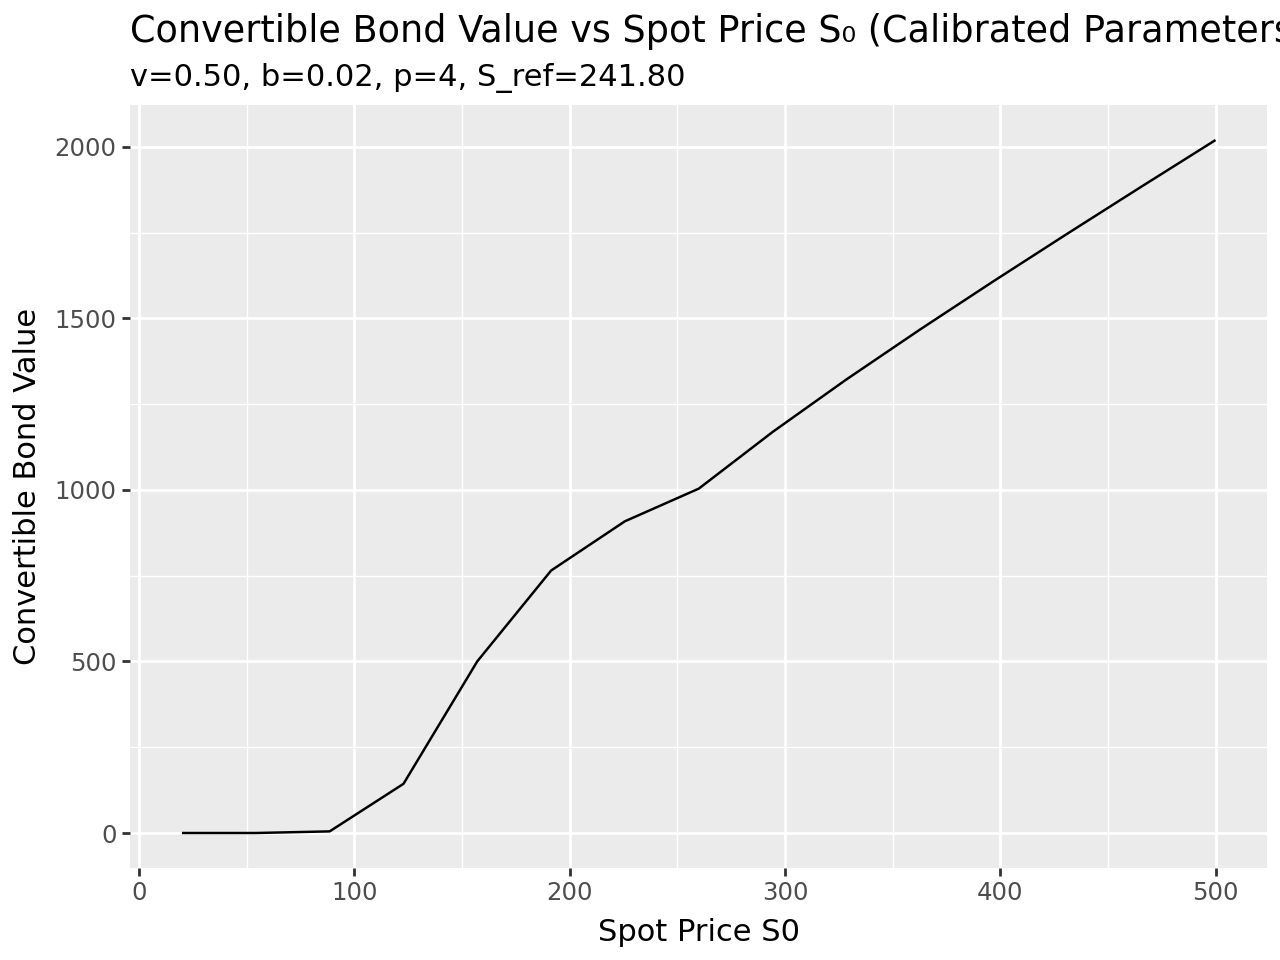

In [13]:
(
    p9.ggplot(conv_vs_S_df, p9.aes(x="S0", y="ConvertiblePrice"))
    + p9.geom_line()
    + p9.xlab("Spot Price S0")
    + p9.ylab("Convertible Bond Value")
    + p9.labs(
        title="Convertible Bond Value vs Spot Price S₀ (Calibrated Parameters)",
        subtitle=f"v={best_v:.2f}, b={best_b:.2f}, p={best_p:d}, S_ref={S_ref:.2f}",
    )
)


At low spot levels the convertible behaves like a discounted bond because conversion is out of the money. As the equity rally pushes the conversion feature in the money, the value accelerates and increasingly mirrors the underlying stock price.

### 6. Quick Self-Tests / Smoke Tests

In [14]:
# Core object existence
assert isinstance(rf_curve_cb, pd.DataFrame)
assert len(euro_options_cb) == 3
assert isinstance(conv_cb, ConvertibleBond)

prices_smoke = find_present_value(
    S0=S0_cb,
    instruments=instruments_cb_all,
    num_time_steps=50,
    default_intensity_fcn=default_intensity_constant,
    discount_factor_fcn=discount_factor_cb,
    const_volatility=sigma_const,
    std_devs_width=std_devs_width_cb,
)

assert all(np.isfinite(list(prices_smoke.values())))
assert np.isfinite(option_mse_for_params(0.45, 0.05, 3))
assert np.isfinite(price_convertible_for_params(best_v, best_b, best_p))

S_test = np.linspace(50, 300, 6)
conv_vals = [price_conv_vs_S0(S, best_v, best_b, best_p) for S in S_test]
assert all(x <= y + 1e-6 for x, y in zip(conv_vals, conv_vals[1:]))
